This section allows to create all possible combinations of hyperparameters with different preprocessing stages.

In [ ]:
import pandas as pd
from utility import Dataset, oh_encoder, l_encoder, scaler, get_best_features,  pca, cfs, rfe, sfs
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report

columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'label', 'score']

nominal_features = ['protocol_type', 'service', 'flag']
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
numeric_features = [feature for feature in columns if feature not in nominal_features + binary_features + ['label', 'score', 'num_outbound_cmds']]

starting_train_df = pd.read_csv(f'dataset/nsl-kdd/KDDTrain+.txt', header=None)
starting_test_df = pd.read_csv(f'dataset/nsl-kdd/KDDTest+.txt', header=None)

def pipeline(train_df, test_df, type):
    models = {
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'LinearSVC': LinearSVC(),
        'GaussianNB': GaussianNB()
    }

    y_train = train_df['label']
    y_test = test_df['label']

    with open('results/results.txt', 'a') as f:
        f.write(f"{type} dataset\n")
        n_features = X_train.shape[1]
        for k in range(1, n_features + 1):
            for method in [mutual_info_classif, mutual_info_classif, chi2  ]:
                print(f"Selecting {k} best features using {method.__name__}...")
                X_train, X_test = get_best_features(train_df, test_df, method, k)
                # X_train, X_test = rfe(train_df, test_df, k)
                # X_train, X_test = sfs(train_df, test_df, k)

                for name, model in models.items():
                    print(f"Training {name}...")
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    f.write(f"Selecting {k} best features using {method.__name__}...\n")
                    f.write(f"{name}...\n")
                    f.write(classification_report(y_test, y_pred, target_names=model.classes_))

            X_train, X_test = pca(train_df, test_df, k)
            print(f"Selecting {k} best features using PCA...")

            for name, model in models.items():
                print(f"Training {name}...")
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                f.write(f"Selecting {k} best features using PCA...\n")
                f.write(f"{name}...\n")
                f.write(classification_report(y_test, y_pred, target_names=model.classes_))
        
        X_train, X_test = cfs(train_df, test_df)
        print(f"Selecting best features using CFS...")

        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f.write(f"Selecting best features using CFS...\n")
            f.write(f"{name}...\n")
            f.write(classification_report(y_test, y_pred, target_names=model.classes_))

In [ ]:
# choose if run binary or multiclass classification

train_df = Dataset(starting_train_df, columns).get_label2()
test_df = Dataset(starting_test_df, columns).get_label2()

# train_df = Dataset(starting_train_df, columns).get_label5()
# test_df = Dataset(starting_test_df, columns).get_label5()

In [ ]:
train_df, test_df = scaler(train_df, test_df, numeric_features, MinMaxScaler())

In [ ]:
# choose which encoding to use

train_df, test_df = l_encoder(train_df, test_df, ['service', 'protocol_type', 'flag'])

# train_df, test_df = oh_encoder(train_df, test_df, ['protocol_type', 'flag', 'service'])

In [ ]:
pipeline(train_df, test_df, 'Binary, scaled, label_encoded')

# One-class classification

In [4]:
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt

from utility import Dataset, l_encoder, scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'label', 'score']

nominal_features = ['protocol_type', 'service', 'flag']
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
numeric_features = [feature for feature in columns if feature not in nominal_features + binary_features + ['label', 'score', 'num_outbound_cmds']]

train_df = pd.read_csv(f'dataset/nsl-kdd/KDDTrain+.txt', header=None)
test_df = pd.read_csv(f'dataset/nsl-kdd/KDDTest+.txt', header=None)

train_df = Dataset(train_df, columns).get_label5()
test_df = Dataset(test_df, columns).get_label5()

train_df, test_df = l_encoder(train_df, test_df, ['service', 'protocol_type', 'flag'])
train_df, test_df = scaler(train_df, test_df, numeric_features, StandardScaler())

X_train = train_df[train_df['label'] == 'normal'].drop(columns=['label'])
y_train = train_df[train_df['label'] == 'normal']['label']
X_test = test_df[test_df['label'] == 'normal'].drop(columns=['label'])
y_test = test_df[test_df['label'] == 'normal']['label']

X_train_outliers = train_df[train_df['label'] != 'normal'].drop(columns=['label'])
y_train_outliers = train_df[train_df['label'] != 'normal']['label']
X_test_outliers = test_df[test_df['label'] != 'normal'].drop(columns=['label'])
y_test_outliers = test_df[test_df['label'] != 'normal']['label']

param_grid = {
    'kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.5],
    'nu': [0.1, 0.05, 0.01, 0.001]
}

clf = svm.OneClassSVM()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train)    
print("Best parameters found: ", grid_search.best_params_)
clf = svm.OneClassSVM(**grid_search.best_params_)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_train_outliers)
y_pred_outliers_test = clf.predict(X_test_outliers)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
n_error_outliers += y_pred_outliers_test[y_pred_outliers_test == 1].size

y_pred_train = ['attack' if x == -1 else 'normal' for x in y_pred_train]
y_pred_test = ['attack' if x == -1 else 'normal' for x in y_pred_test]
y_pred_outliers = ['attack' if x == -1 else 'normal' for x in y_pred_outliers]
y_pred_outliers_test = ['attack' if x == -1 else 'normal' for x in y_pred_outliers_test]

y_true_train = ['normal'] * len(y_pred_train)
y_true_test = ['normal'] * len(y_pred_test)
y_true_outliers = ['attack'] * len(y_pred_outliers)
y_true_outliers_test = ['attack'] * len(y_pred_outliers_test)

y_true = y_true_test + y_true_outliers + y_true_outliers_test
y_pred = y_pred_test + y_pred_outliers + y_pred_outliers_test
print(classification_report(y_true, y_pred))


c:\Users\crist\miniconda3\envs\envTesi\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best parameters found:  {'gamma': 0.5, 'kernel': 'rbf', 'nu': 0.01}
              precision    recall  f1-score   support

      attack       0.98      0.98      0.98     71463
      normal       0.85      0.87      0.86      9711

    accuracy                           0.97     81174
   macro avg       0.91      0.93      0.92     81174
weighted avg       0.97      0.97      0.97     81174



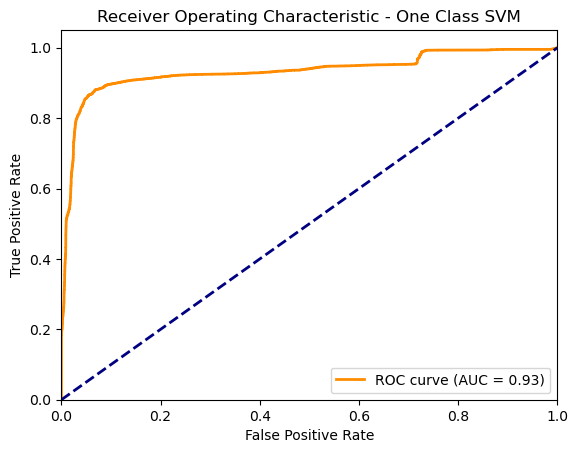

AUC:  0.9326699008017596


In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
y_true_train = [1] * len(y_pred_train)
y_true_test = [1] * len(y_pred_test)
y_true_outliers = [-1] * len(y_pred_outliers)
y_true_outliers_test = [-1] * len(y_pred_outliers_test)

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
y_test = [1 if x == 'normal' else -1 for x in y_test]

decision_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)
auc_score = roc_auc_score(y_test, decision_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - One Class SVM')
plt.legend(loc="lower right")
plt.show()

print("AUC: ", auc_score)

Save the model for later use

In [13]:
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv(f'dataset/nsl-kdd/KDDTrain+.txt', header=None)

train_df = Dataset(train_df, columns).get_label5()

scaler = StandardScaler()
scaler.fit(train_df[numeric_features])

encoder_service = LabelEncoder()
encoder_service.fit(train_df['service'])
encoder_protocol_type = LabelEncoder()
encoder_protocol_type.fit(train_df['protocol_type'])
encoder_flag = LabelEncoder()
encoder_flag.fit(train_df['flag'])

joblib.dump(clf, 'model/one_class_svm_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(encoder_service, 'model/encoder_service.pkl')
joblib.dump(encoder_protocol_type, 'model/encoder_protocol_type.pkl')
joblib.dump(encoder_flag, 'model/encoder_flag.pkl')

['model/encoder_flag.pkl']